In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import math, torch, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR, MultiplicativeLR
import torch.nn as nn
import matplotlib.pyplot as plt
import sys, os
import mpl_toolkits.mplot3d as p3d
from scipy import linalg
import utility, problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）


In [3]:
torch.set_default_dtype(torch.float64)
plt.rcParams.update({'font.size': 20})
def u_exact(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
        x3 = x[:,2]
    return torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2) * torch.sin(torch.pi * x3)

def f(x):
    if x.ndim == 1:
        x1 = x[0]
        x2 = x[1]
        x3 = x[2]
    else:
        x1 = x[:,0]
        x2 = x[:,1]
        x3 = x[:,2]
    return 3 * torch.pi**2 * torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2) * torch.sin(torch.pi * x3)

### PD-OFM

Loss at Step 10 is 97.47128952038885 with pde loss 80.57114521659202 , orthogonal loss 1690.0144303796835 and rank of matrix 18.
Loss at Step 20 is 54.8740088813664 with pde loss 45.07821327689426 , orthogonal loss 979.5795604472141 and rank of matrix 31.
Loss at Step 30 is 25.477100636095308 with pde loss 16.980740221902675 , orthogonal loss 849.6360414192635 and rank of matrix 49.
Loss at Step 40 is 15.132001671979644 with pde loss 8.349982678803842 , orthogonal loss 678.2018993175802 and rank of matrix 63.
Loss at Step 50 is 8.88902224524956 with pde loss 4.794090990948347 , orthogonal loss 409.4931254301214 and rank of matrix 62.
Loss at Step 60 is 5.633604259142828 with pde loss 2.4034805751687753 , orthogonal loss 323.0123683974053 and rank of matrix 63.
Loss at Step 70 is 3.8039672056793337 with pde loss 1.2352954334160127 , orthogonal loss 256.8671772263321 and rank of matrix 62.
Loss at Step 80 is 2.961945742945721 with pde loss 0.8866195818508417 , orthogonal loss 207.5326161

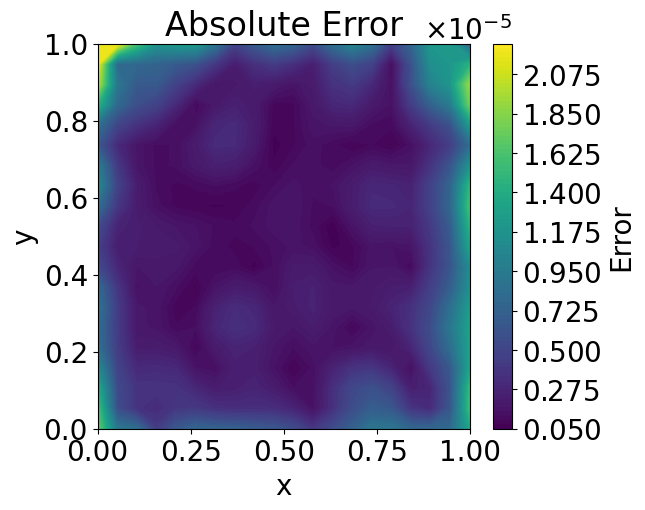

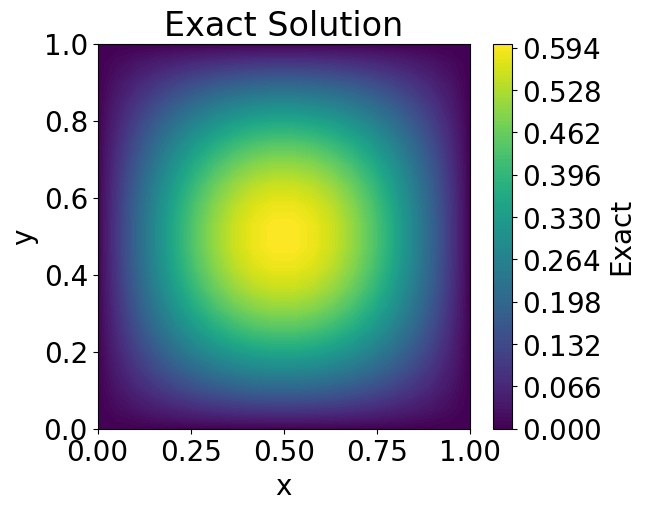

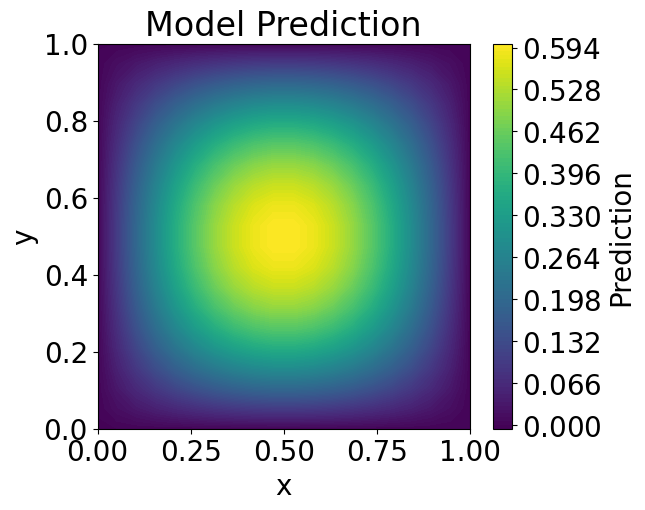

In [3]:
Pro = problem.PoissonBox3D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {"radius": 1, "d": 3, "bodyBatch": 2048, "bdryBatch": 600, "lr": 0.001, "width": 600, "depth": 2, "trainStep": 100, "bdry_penalty": 1, "writeStep": 10, "plotStep": 200, "decay": 0.0001, "lambda": 10, "epsilon": 1e-3, "orthogonalpenalty": 0.01, "beta": 1}
params["dd"] = params["width"]
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)  #trainnew model

### PD-FM

Loss at Step 10 is 60.08338168666465 with pde loss 60.08338168666465 , orthogonal loss 12125.014220579527 and rank of matrix 24.
Loss at Step 20 is 46.866999478716934 with pde loss 46.866999478716934 , orthogonal loss 9846.074281077092 and rank of matrix 32.
Loss at Step 30 is 23.87489795046462 with pde loss 23.87489795046462 , orthogonal loss 9427.09104561813 and rank of matrix 52.
Loss at Step 40 is 9.228133057573107 with pde loss 9.228133057573107 , orthogonal loss 11207.662291823875 and rank of matrix 74.
Loss at Step 50 is 4.183847580235561 with pde loss 4.183847580235561 , orthogonal loss 13404.831088430601 and rank of matrix 80.
Loss at Step 60 is 2.1022237075297454 with pde loss 2.1022237075297454 , orthogonal loss 17074.14635533279 and rank of matrix 85.
Loss at Step 70 is 0.9999969272076525 with pde loss 0.9999969272076525 , orthogonal loss 18943.674127044098 and rank of matrix 87.
Loss at Step 80 is 0.4589377644102188 with pde loss 0.4589377644102188 , orthogonal loss 20067.

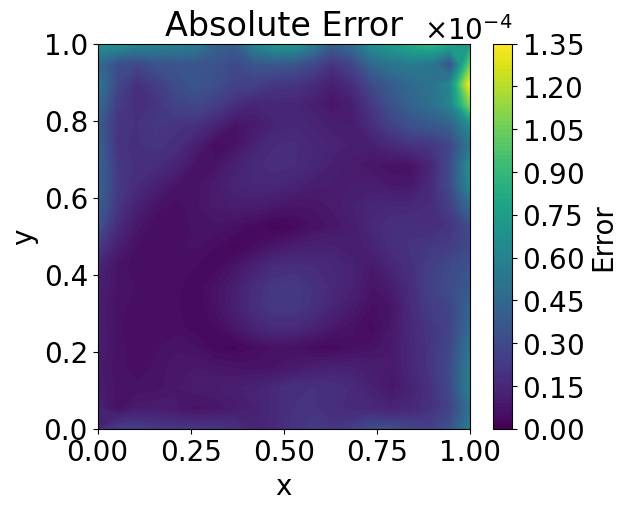

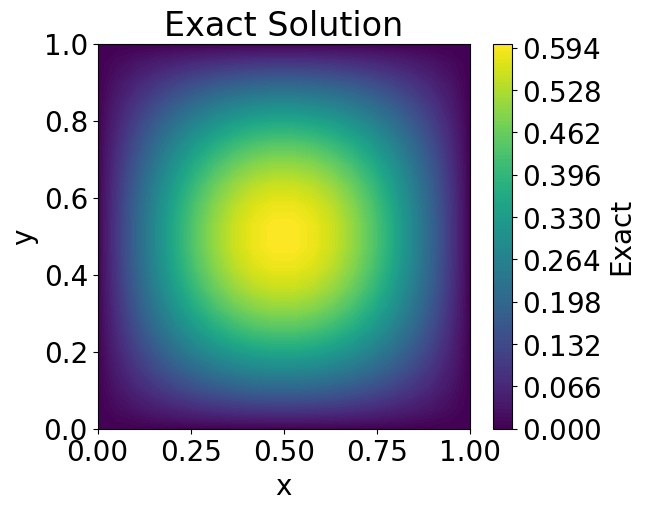

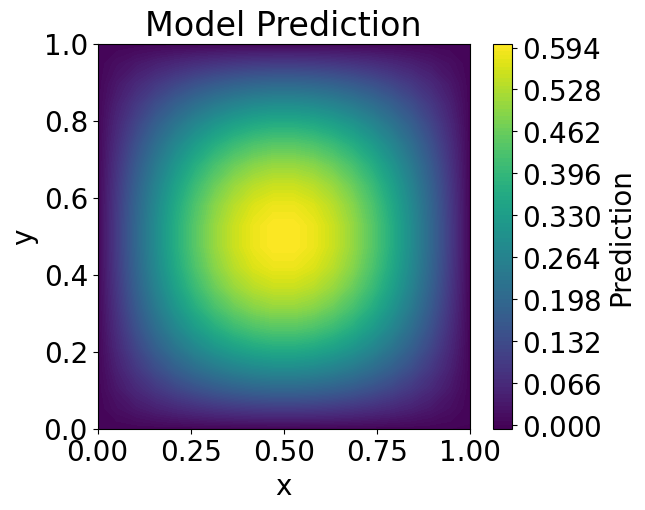

In [4]:
Pro = problem.PoissonBox3D(f, u_exact, u_exact, 1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params = {"radius": 1, "d": 3, "bodyBatch": 2048, "bdryBatch": 600, "lr": 0.001, "width": 600, "depth": 2, "trainStep": 100, "bdry_penalty": 1, "writeStep": 10, "plotStep": 200, "decay": 0.0001, "lambda": 10, "epsilon": 1e-3, "orthogonalpenalty": 0, "beta": 1}
params["dd"] = params["width"]
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = utility.trainnew(model,Pro,device,params,optimizer)  #trainnew model

### Transnet

best shape parameter:  0.8
the error of least square in problem poisson3d:  0.00014195663046428063
the effective rank of basis in problem poisson3d is 32 with threshold 0.001
the l2 relative error in problem poisson3d:  0.0002484775319359387
the maximum pointwise error in problem poisson3d:  0.0005069283070042729


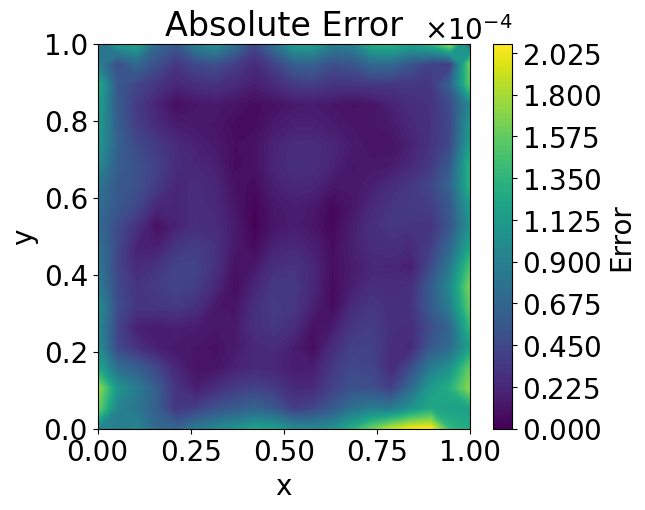

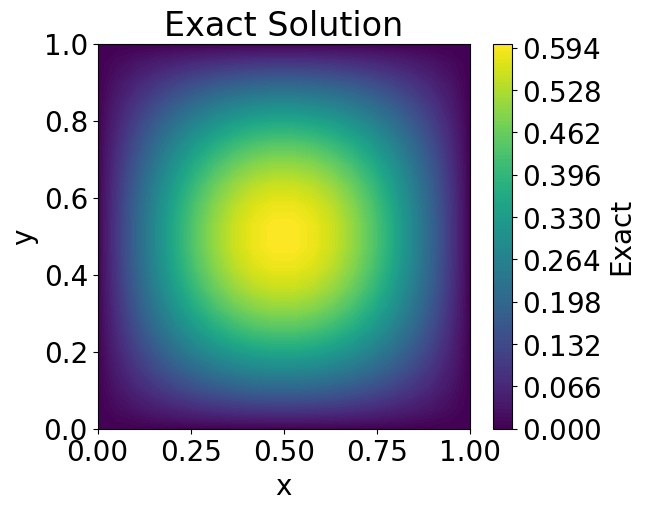

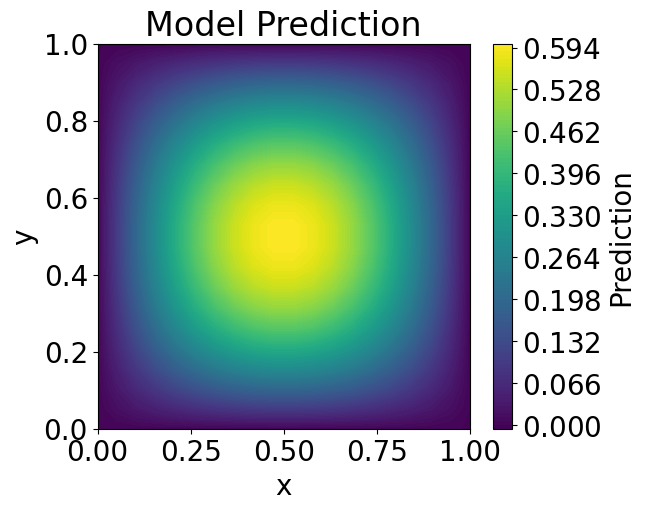

In [3]:
set_seed(42)

### Initializing TransNet and Problem
device = "cpu"
Pro = problem.PoissonBox3D(f, u_exact, u_exact, domain_size=1, device=device)
params = dict()
params = {"radius": 0.9, "d": 3, "bodyBatch": 2048, "bdryBatch":600, "width": 600}
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True
model = net.TransNet(params["d"], params["width"], params["radius"],shape_parameter=0.8).to(device)
model.set_center(torch.tensor([0.5,0.5,0.5]))
print("best shape parameter: ", model.shape_parameter)

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)

### Random Feature Model

the error of least square in problem poisson3d:  0.010098361094754578
the effective rank of basis in problem poisson3d is 396 with threshold 0.001
the l2 relative error in problem poisson3d:  0.19897213993708696
the maximum pointwise error in problem poisson3d:  0.4257209343364883


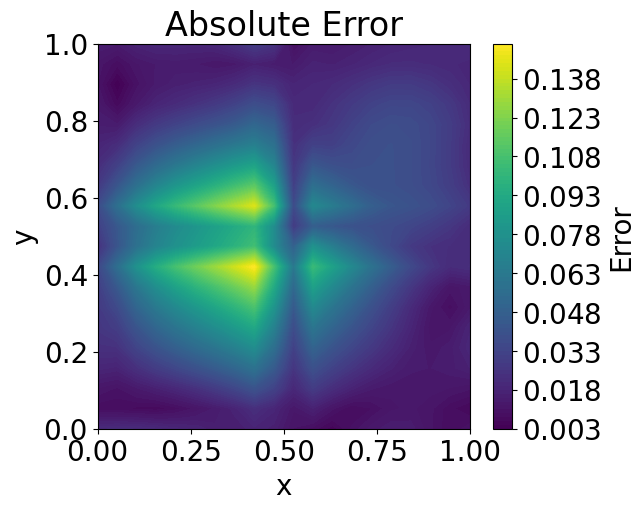

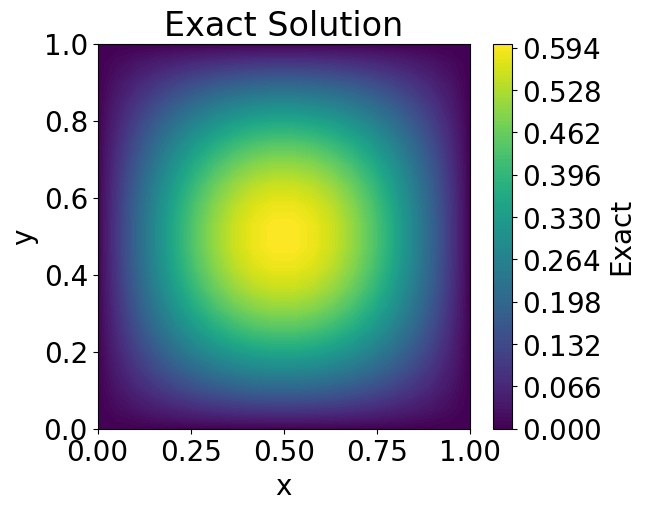

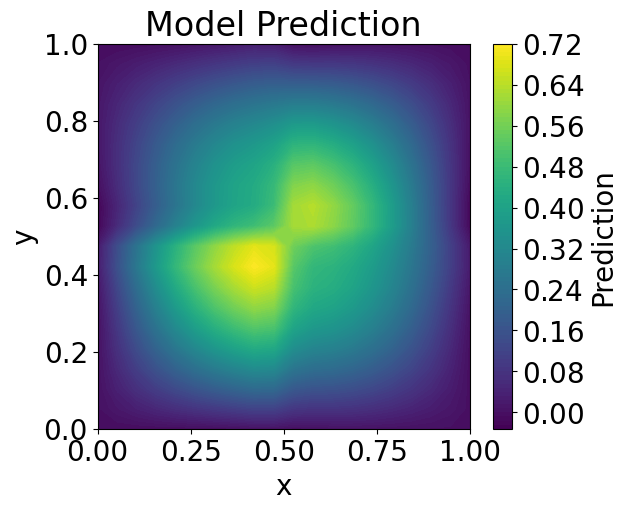

In [6]:
device="cpu"
set_seed(42)

### Initializing RFM and Problem
params = dict()
params = {"d": 3, "bodyBatch": 2048, "bdryBatch":256, "number_basis": 600}
centers = torch.tensor([[0.25, 0.25, 0.25], [0.75, 0.25, 0.25],
                        [0.25, 0.75, 0.25], [0.75, 0.75, 0.25],
                        [0.25, 0.25, 0.75], [0.75, 0.25, 0.75],
                        [0.25, 0.75, 0.75], [0.75, 0.75, 0.75]], dtype=torch.float64)
radius = torch.tensor([[0.25, 0.25, 0.25]] * 8, dtype=torch.float64)
model = net.RFM(params, centers, radius, typeofPoU="b", device=device).to(device)
Pro = problem.PoissonBox3D(f, u_exact, u_exact, domain_size=1, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"]) 
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True

### Solving Least Sqaure Problem
(A, rhs) = Pro.leastsquareproblem(model, int_data, bdry_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)